# Import library

In [8]:
import os
import sys
import traci
from sumolib import checkBinary 
import pandas as pd

if 'SUMO_HOME' in os.environ:
  tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
  sys.path.append(tools)
else:
  sys.exit("please declare environment variable 'SUMO_HOME'")

# Set the variable
Logic 
1. Number of vehicles in each lane - halting vehicle + non-halting
2. Number of halting vehicles 
3. Propotion of vehicles and number of lane

Index phases from Traffic light logic
- North -> 0 (-E2, 66)
- South -> 2 (-E0, 71)
- West -> 4 (-E1, 45)
- East -> 6 (-E3, 50)

In [9]:
useGui = False
logic = 3
yellowTime = 5
vphs = [1000,2000,3000,4000,5000]
num_lane = [3, 4, 2, 2]
edge_name = {0: '-E2', 1: '-E0', 2: '-E1', 3: '-E3'}
standard_time = [66, 71, 45, 50] # north, south, west, east

# Function 

In [10]:
def getEdgeHaltingVehicles(edge):
  return traci.edge.getLastStepHaltingNumber(edge)

def getEdgeTotalVehicles(edge):
  return traci.edge.getLastStepVehicleNumber(edge)

def getEdgeWaitingTime(edge):
  return traci.edge.getWaitingTime(edge)

def getEdgeAccumulativeWaitingTime(edge):
  # get all vehicles ID and then get accumulative waiting time for each car ID
  return sum(traci.vehicle.getAccumulatedWaitingTime(vehicle) for vehicle in traci.edge.getLastStepVehicleIDs(edge))
 
def totalVehicle(lanes: list):
  numVehicleList = [traci.lane.getLastStepVehicleNumber(lane) for lane in lanes]
  return sum(numVehicleList)

# Experiment

In [14]:
simulation_data = pd.DataFrame(columns=['Vehicles Per Hour', 'Accumulated Time', 'Clear Time'])
total_cars_data = {}
for i in vphs:
  net_file = './saint_paul/junction.net.xml'
  route_path = f'./saint_paul/1.0hour/trips/{i}.rou.xml'

  if(useGui): sumoBinary = checkBinary('sumo-gui')
  else: sumoBinary = checkBinary('sumo')
  sumoCmd = [sumoBinary, "-n", net_file, "-r", route_path, "--quit-on-end", "--waiting-time-memory", '10000', '--time-to-teleport', '-1']

  traci.start(sumoCmd)

  trafficLightId = traci.trafficlight.getIDList()[0]
  allLanes = list(dict.fromkeys(traci.trafficlight.getControlledLanes(trafficLightId))) # remove duplicate
  allPhases = traci.trafficlight.getAllProgramLogics(trafficLightId)[0].phases
  
  switchTime = 0
  currentPhase = 0
  yellowPhase = False
  latest_time = [0, 0, 0, 0]

  waiting_time = {}
  halting_cars = []
  all_car_in_sim = []
  proportion_lane = [1, 1, 1, 1]
  time = []

  while traci.simulation.getMinExpectedNumber() > 0:
    traci.simulationStep()
    currentTime = traci.simulation.getTime()
    #find the next phases to open (yellow and green)
    if currentTime >= switchTime:
      # Swicth to green phase
      if yellowPhase:
        currentPhase = (currentPhase + 1) % 4
        if logic == 1:
          totalVehicles = getEdgeTotalVehicles(edge_name[currentPhase])
          switchTime += min(max(15, int(totalVehicles / (0.45 * num_lane[currentPhase]))), 120)
        elif logic == 2:
          totalHaltingVehicles = getEdgeHaltingVehicles(edge_name[currentPhase])
          switchTime += min(max(15, int(totalHaltingVehicles / (num_lane[currentPhase]))*1.08), 120)
          # switchTime += min(max(15, int(totalHaltingVehicles / (0.45 * num_lane[currentPhase]))), 120)
        elif logic == 3:
          realCars = getEdgeHaltingVehicles(edge_name[currentPhase])
          expectedCars = num_lane[currentPhase] * 0.45 * standard_time[currentPhase]
          switchTime += int(standard_time[currentPhase] * realCars/expectedCars)

        yellowPhase = False
        traci.trafficlight.setRedYellowGreenState(trafficLightId, allPhases[currentPhase*2].state)
      # Swicth to yellow phase before switch to green phase
      else:
        traci.trafficlight.setRedYellowGreenState(trafficLightId, allPhases[currentPhase*2 + 1].state)
        switchTime += yellowTime
        yellowPhase = True

    vehicles = traci.vehicle.getIDList()

    all_car_in_sim.append(len(vehicles))
    halting_cars.append(sum(getEdgeHaltingVehicles(edge) for edge in edge_name.values()))
    
    for vehicle in vehicles:
      vehicle_waiting_time = traci.vehicle.getAccumulatedWaitingTime(vehicle)
      if(vehicle not in waiting_time):
        waiting_time[vehicle] = vehicle_waiting_time
      else:
        waiting_time[vehicle] = max(vehicle_waiting_time, waiting_time[vehicle])
    total_clear_time = currentTime

  total_waiting_time = sum(waiting_time[vehicle] for vehicle in waiting_time)
  total_cars_data[i] = {'All Cars': all_car_in_sim, 'Halting Cars': halting_cars}
  simulation_data.loc[len(simulation_data.index)] = [i, total_waiting_time, total_clear_time]  
  print('\n', i, total_waiting_time, total_clear_time)
    
  traci.close()

 Retrying in 1 seconds



 1000 12210.0 4022.0
Step #4022.00 (0ms ?*RT. ?UPS, TraCI: 3ms, vehicles TOT 1004 ACT 0 BUF 0)                 
 Retrying in 1 seconds



 2000 54793.0 4011.0
Step #4011.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 2009 ACT 0 BUF 0)                 
 Retrying in 1 seconds



 3000 110250.0 4042.0
Step #4042.00 (0ms ?*RT. ?UPS, TraCI: 4ms, vehicles TOT 3008 ACT 0 BUF 0)                 
 Retrying in 1 seconds


Step #700.00 (1ms ~= 1000.00*RT, ~421000.00UPS, TraCI: 14ms, vehicles TOT 672 ACT 421 BUF 
 4000 305722.0 4174.0
Step #4174.00 (0ms ?*RT. ?UPS, TraCI: 4ms, vehicles TOT 4005 ACT 0 BUF 0)                 
 Retrying in 1 seconds


Step #2100.00 (2ms ~= 500.00*RT, ~397000.00UPS, TraCI: 25ms, vehicles TOT 2922 ACT 794 BUF
 5000 1437057.0 4721.0
Step #4721.00 (0ms ?*RT. ?UPS, TraCI: 5ms, vehicles TOT 5008 ACT 0 BUF 0)                 


# Plot graph

### Plot experiment

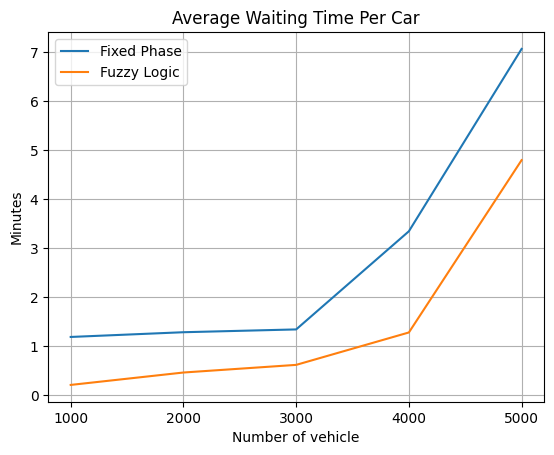

In [15]:
import matplotlib.pyplot as plt

df = pd.read_csv('./saint_paul_1hr.csv')

plt.plot(simulation_data['Vehicles Per Hour'], df['waiting_fixed'] /simulation_data['Vehicles Per Hour']/60, label = "Fixed Phase")
plt.plot(simulation_data['Vehicles Per Hour'], simulation_data['Accumulated Time']/simulation_data['Vehicles Per Hour']/60, label = "Fuzzy Logic")
plt.xticks(simulation_data['Vehicles Per Hour'])
plt.xlabel('Number of vehicle')
plt.ylabel('Minutes')
plt.title('Average Waiting Time Per Car')
plt.grid()
plt.legend()
plt.show()

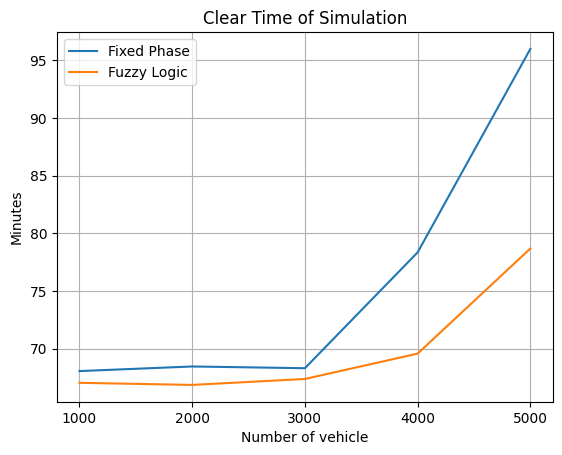

In [17]:
plt.plot(simulation_data['Vehicles Per Hour'], df['clear_fixed']/60, label = "Fixed Phase")
plt.plot(simulation_data['Vehicles Per Hour'], simulation_data['Clear Time']/60, label = "Fuzzy Logic")
plt.xticks(simulation_data['Vehicles Per Hour'])
plt.xlabel('Number of vehicle')
plt.ylabel('Minutes')
plt.title('Clear Time of Simulation')
plt.grid()
plt.legend()
plt.show()

### Number of cars

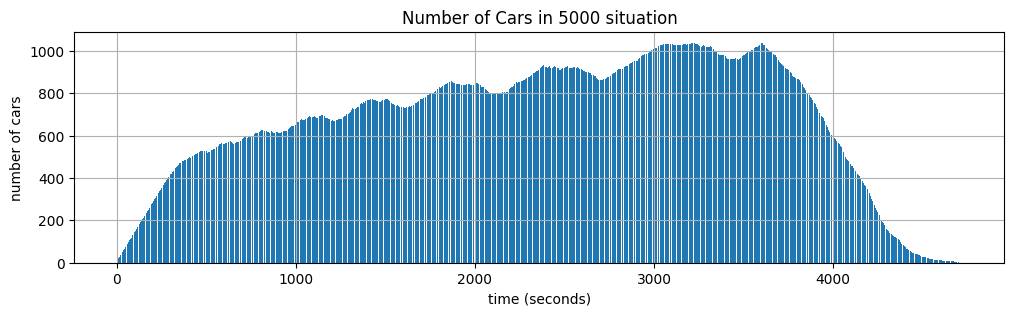

In [44]:
num = 5000
clearTime = int(list(simulation_data.loc[simulation_data['Vehicles Per Hour']==num, 'Clear Time'])[0])

time = [t for t in range(clearTime)]
number_of_cars = total_cars_data[num]['All Cars']

plt.subplots(figsize=(12, 3))
plt.bar(time, number_of_cars)
plt.title(f'Number of Cars in {i} situation')
plt.xlabel('time (seconds)')
plt.ylabel('number of cars')
plt.grid()
plt.show()

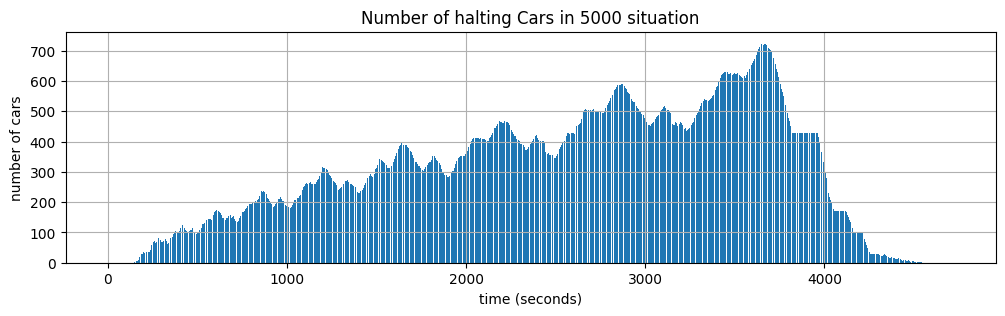

In [43]:
clearTime = int(list(simulation_data.loc[simulation_data['Vehicles Per Hour']==num, 'Clear Time'])[0])

time = [t for t in range(clearTime)]
number_of_cars = total_cars_data[num]['Halting Cars']

plt.subplots(figsize=(12, 3))
plt.bar(time, number_of_cars)
plt.title(f'Number of halting Cars in {i} situation')
plt.xlabel('time (seconds)')
plt.ylabel('number of cars')
plt.grid()
plt.show()